In [ ]:
import os

download_name = "reviews_with_splits_lite.csv.bz2"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/lectures/p02/{download_name}")
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()
        
name = "reviews_with_splits_lite.csv"
if not os.path.exists(name):
    import bz2
    with open(download_name, 'rb') as bzf, open(name, 'wb') as fp:
        fp.write(bz2.decompress(bzf.read()))  

# YELP Classify

In [1]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [2]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self): 
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return f"<Vocabulary(size={len(self)})>"

    def __len__(self):
        return len(self._token_to_idx)


vocab = Vocabulary()

vocab.add_token("john")
vocab.add_token("john")
vocab.add_token("ann")

vocab.lookup_token("john"), vocab.lookup_index(2)


(1, 'ann')

In [3]:
class ReviewVectorizer(object):
    def __init__(self, review_vocab, rating_vocab):
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

review_vocab = Vocabulary()
review_vocab.add_many("john has been there . but he is not john .".split())

rating_vocab = Vocabulary(add_unk=False)
rating_vocab.add_many(["positive", "negative"])

vectorizer = ReviewVectorizer(review_vocab, rating_vocab)
vectorizer.vectorize("but john has not been he .")

array([0., 1., 1., 1., 0., 0., 1., 1., 0., 1.], dtype=float32)

### Read Dataset

In [4]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': self.train_df,
                             'val': self.val_df,
                             'test': self.test_df}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df = self._lookup_dict[split]

    def __len__(self):
        return len(self._target_df)

    def __getitem__(self, index):
        row = self._target_df.iloc[index]

        review_vector = self._vectorizer.vectorize(row.review)

        rating_index = self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


In [5]:

args = Namespace(
    # Data and Path information
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv='reviews_with_splits_lite.csv',

    # review_csv='data/yelp/reviews_with_splits_full.csv',
    save_dir='',
    vectorizer_file='vectorizer.json',
    
    # No Model hyper parameters
    # Training hyper parameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

In [6]:
dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
vectorizer = dataset.get_vectorizer()

In [7]:

vectorizer.review_vocab
len(vectorizer.review_vocab)

7326

In [8]:
dataloader = DataLoader(dataset=dataset)

x_data = []
y_target = []

i = 0
for item in tqdm(dataloader):
    x_data.append(item["x_data"].squeeze())
    y_target.append(item["y_target"].squeeze())

    
x_data = torch.stack(x_data)
y_target = torch.stack(y_target)


  0%|          | 0/39200 [00:00<?, ?it/s]

## Plot data

In [9]:
from sklearn import decomposition
import matplotlib.pyplot as plt

In [10]:
pca = decomposition.PCA(n_components=2)
pca.fit(x_data)
X = pca.transform(x_data)

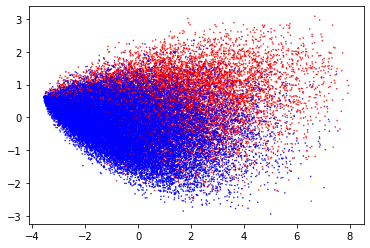

In [11]:
colors = ["red" if y_i == 0 else "blue" for y_i in y_target]


plt.scatter(X[:,0], X[:,1], marker=".", s=1, c=colors)


### Model Classifier

In [12]:
class ReviewClassifier(nn.Module):

    def __init__(self, num_features):
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, 
                             out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out


### Initialization

In [13]:
dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
dataset.save_vectorizer(args.vectorizer_file)    
vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))

args.device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
classifier = classifier.to(args.device)

# Training

In [14]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred) > 0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

for epoch_index in range(args.num_epochs):
    # TRAIN
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
    
    print(f"Train epoch: {epoch_index}/{args.num_epochs} loss: {running_loss} acc: {running_acc}")            

    # VAL
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)
        
    print(f"Valid epoch: {epoch_index}/{args.num_epochs} loss: {running_loss} acc: {running_acc}")                 
    scheduler.step(running_loss)



Train epoch: 0/100 loss: 0.4797094320160113 acc: 84.14266748366018
Valid epoch: 0/100 loss: 0.38287443839586704 acc: 88.14903846153845
Train epoch: 1/100 loss: 0.33055961808932344 acc: 90.1654411764706
Valid epoch: 1/100 loss: 0.3103707471719155 acc: 90.46875000000003
Train epoch: 2/100 loss: 0.2761893602562884 acc: 91.577308006536
Valid epoch: 2/100 loss: 0.2748257061609855 acc: 91.06971153846156
Train epoch: 3/100 loss: 0.2454287240805187 acc: 92.27941176470591
Valid epoch: 3/100 loss: 0.25346964941574973 acc: 91.59855769230772
Train epoch: 4/100 loss: 0.22554011837719312 acc: 92.79258578431377
Valid epoch: 4/100 loss: 0.24018149009117712 acc: 91.89903846153845
Train epoch: 5/100 loss: 0.21073942948010999 acc: 93.08874591503265
Valid epoch: 5/100 loss: 0.230384679711782 acc: 92.0673076923077
Train epoch: 6/100 loss: 0.19935661749122974 acc: 93.40277777777777
Valid epoch: 6/100 loss: 0.22364566532465133 acc: 92.15144230769234
Train epoch: 7/100 loss: 0.19019577472038535 acc: 93.568729

# Test

In [15]:
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

print(f"Test loss: {running_loss} acc: {running_acc}") 

Test loss: 0.2175067478647599 acc: 91.82692307692305


# Inference

In [21]:
import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    review = preprocess_text(review)
    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1).to(args.device))

    probability_value = torch.sigmoid(result).item()

    index =  1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index)

test_review = "this is a pretty awesome notebook"
prediction = predict_rating(test_review, classifier, vectorizer)
print(f"{test_review} -> {prediction}")


this is a pretty awesome notebook -> positive


# Interpretability

In [23]:
fc1_weights = classifier.fc1.weight.cpu().detach()[0]
weights, indices = torch.sort(fc1_weights, dim=0, descending=True)

indices = indices.numpy().tolist()


# Top 20 words
print("Influential words in Positive Reviews:")
print("--------------------------------------")
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))
    
print("====\n\n\n")

# Top 20 negative words
print("Influential words in Negative Reviews:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))


Influential words in Positive Reviews:
--------------------------------------
delicious
pleasantly
fantastic
amazing
vegas
great
yum
ngreat
excellent
perfect
yummy
awesome
bomb
chinatown
deliciousness
love
hooked
solid
pleased
notch
====



Influential words in Negative Reviews:
--------------------------------------
worst
mediocre
bland
horrible
meh
awful
rude
terrible
tasteless
unacceptable
overpriced
slowest
disgusting
poorly
unfriendly
nmaybe
underwhelmed
disappointment
downhill
disappointing
